In [4]:
# Magic + imports
%load_ext autoreload
%autoreload 2
%matplotlib inline

CMAP = "Blues"

In [5]:
# set path
import sys
sys.path.append('/home/jovyan/odc-hub/')
# import required modules
import warnings
warnings.filterwarnings('ignore')
import xarray as xr 
import functools as fct
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce 
import pandas as pd

# import required datacube modules
from utils_sac.interactive_maps import display_map
from utils_sac.notebook_animation_widgets import create_movie_on_np_array
from utils_sac.plotting import plot_availability

import utils_sac.waterline_functions_deaafrica as waterline_funcs
from utils_sac.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify

import datacube
dc = datacube.Datacube(app='wofs dask')

In [6]:
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
chunks={'x':100, 'y':100}

In [7]:
lon_range = (177.481, 177.855)
lat_range = (-18.00, -18.3732)
#smaller area
#lon_range = (177.36740112307, 177.46044158938)
#lat_range = (-18.107528686523, -18.159027099609)
time_range = ("2017", "2018")
tide_range = (0.00, 10.00)
time_step = '1Y'
output_projection = "EPSG:32760"

path = "/home/shared/geo_demos/tides/"
tide_file_2017 = "/home/shared/geo_demos/tides/IDO70004_2017.csv"
tide_file_2018 = "/home/shared/geo_demos/tides/IDO70004_2018.csv"


In [8]:
waterline_funcs.display_map(latitude=lat_range, longitude=lon_range)

In [47]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time provided above
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'output_crs': output_projection,  
    'resolution': (-30, 30)
}

In [48]:
landsat_ds = dc.load(product="ls8_usgs_wofs_scene",
               group_by='solar_day',
               #dask_chunks=chunks,
               #measurements = ["green","red", "blue", "nir","swir1","swir2","coastal_aerosol","pixel_qa"],
               measurements = ['water'],
               **query)

In [49]:
print(landsat_ds)

<xarray.Dataset>
Dimensions:  (time: 81, x: 1324, y: 1382)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-07T22:06:49.107044 ... 2018-12-28T22:06:30.216454
  * y        (y) float64 8.01e+06 8.01e+06 8.01e+06 ... 7.968e+06 7.968e+06
  * x        (x) float64 5.508e+05 5.508e+05 5.509e+05 ... 5.905e+05 5.905e+05
Data variables:
    water    (time, y, x) int16 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Attributes:
    crs:      EPSG:32760


In [50]:
clouds = dc.load(**query,
                 product="ls8_usgs_sr_scene",
                 measurements=['pixel_qa'])

valid_data = landsat_qa_clean_mask(clouds, 'LANDSAT_8')
        
# remove cloudy pixels
landsat_ds= landsat_ds.where(valid_data)

In [51]:
print(clouds)
print(landsat_ds)

<xarray.Dataset>
Dimensions:   (time: 153, x: 1324, y: 1382)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-07T22:06:49.107044 ... 2018-12-28T22:06:30.216454
  * y         (y) float64 8.01e+06 8.01e+06 8.01e+06 ... 7.968e+06 7.968e+06
  * x         (x) float64 5.508e+05 5.508e+05 5.509e+05 ... 5.905e+05 5.905e+05
Data variables:
    pixel_qa  (time, y, x) uint16 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    crs:      EPSG:32760
<xarray.Dataset>
Dimensions:  (time: 81, x: 1324, y: 1382)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-07T22:06:49.107044 ... 2018-12-28T22:06:30.216454
  * y        (y) float64 8.01e+06 8.01e+06 8.01e+06 ... 7.968e+06 7.968e+06
  * x        (x) float64 5.508e+05 5.508e+05 5.509e+05 ... 5.905e+05 5.905e+05
Data variables:
    water    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:32760


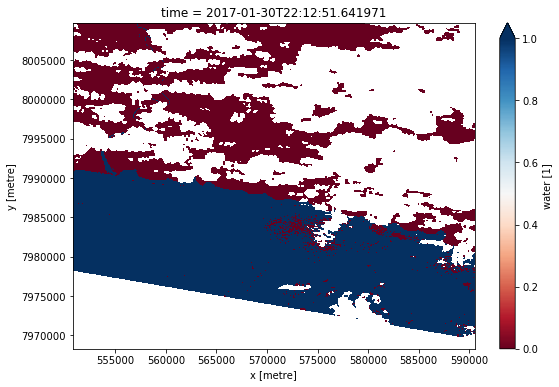

In [52]:
landsat_ds.water.isel(time=3).plot(cmap='RdBu', size=6, vmin=0, vmax=1)

In [53]:
tide_data_2017 = pd.read_csv(tide_file_2017, parse_dates=['time'], index_col='time')
tide_data_2018 = pd.read_csv(tide_file_2018, parse_dates=['time'], index_col='time')
tide_data = pd.concat([tide_data_2017, tide_data_2018])
tide_data.head()
tide_data['tide_height'] = tide_data['tide']
tide_data.head()

,tide,Water Temperature,Air Temperature,Barometric Pressure,Residuals,Adjusted Residuals,Wind Direction,Wind Gust,Wind Speed,Lautoka,Fiji,tide_height
time,,,,,,,,,,,,
2017-01-01 00:00:00,1.082,29.5,29.9,1006.2,-0.069,-0.133,330,3.3,1.0,NaN,NaN,1.082
2017-01-01 01:00:00,0.888,29.6,30.2,1005.7,-0.037,-0.107,347,3.5,1.2,NaN,NaN,0.888
2017-01-01 02:00:00,0.791,29.9,30.4,1005.5,-0.035,-0.111,338,4.5,1.3,NaN,NaN,0.791
2017-01-01 03:00:00,0.885,30.2,30.0,1005.1,-0.008,-0.085,341,4.1,1.7,NaN,NaN,0.885
2017-01-01 04:00:00,1.093,30.3,30.0,1004.8,-0.005,-0.086,303,4.4,1.4,NaN,NaN,1.093


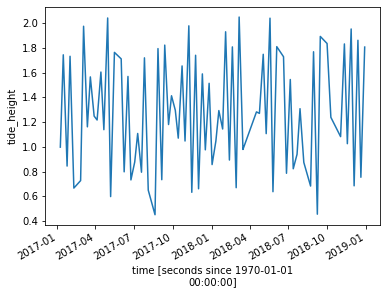

In [54]:
# First, we convert the data to an xarray dataset so we can analyse it in the same way as our Landsat data
tide_data_xr = tide_data.to_xarray()

# We want to convert our hourly tide heights to estimates of exactly how high the tide was at the time that
# each satellite image was taken. To do this, we can use `.interp` to 'interpolate' a tide height for each
# Landsat timestamp:
landsat_tideheights = tide_data_xr.interp(time=landsat_ds.time)
# We then want to put these values back into the Landsat dataset so that each image has an estimated tide height:
landsat_ds['tide_height'] = landsat_tideheights.tide_height

# Plot the resulting tide heights for each Landsat image:
landsat_ds.tide_height.plot()

plt.show()

<xarray.Dataset>
Dimensions:      (time: 81, x: 1324, y: 1382)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-07T22:06:49.107044 ... 2018-12-28T22:06:30.216454
  * y            (y) float64 8.01e+06 8.01e+06 8.01e+06 ... 7.968e+06 7.968e+06
  * x            (x) float64 5.508e+05 5.508e+05 ... 5.905e+05 5.905e+05
Data variables:
    water        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    tide_height  (time) float64 0.9974 1.744 0.8445 1.732 ... 1.861 0.754 1.806
Attributes:
    crs:      EPSG:32760


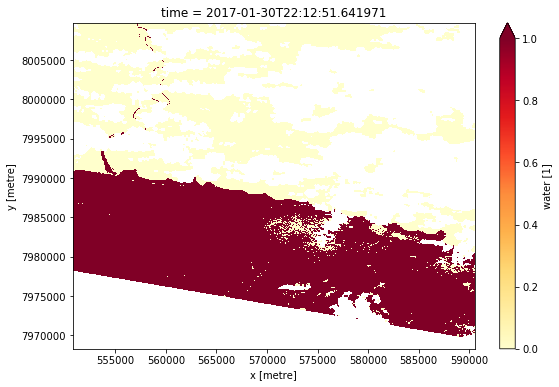

In [55]:
landsat_hightide = landsat_ds.where((landsat_ds.tide_height > tide_range[0]) & 
                                    (landsat_ds.tide_height < tide_range[1]), drop=True)
print(landsat_hightide)
landsat_hightide.water.isel(time=3).plot(cmap='YlOrRd', size=6, vmin=0, vmax=1)

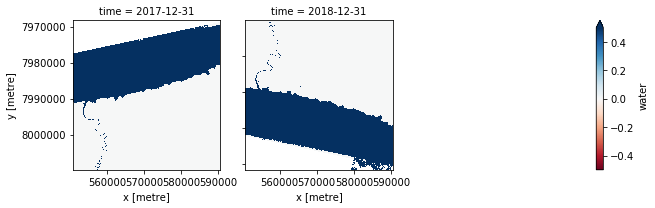

In [65]:
landsat_resampled = landsat_hightide.water.compute().resample(time=time_step).mean('time')
landsat_resampled.plot(col='time', cmap='RdBu', col_wrap=3, vmin=-0.5, vmax=0.5)


In [66]:
print(len(landsat_resampled.time))

2


Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
Exporting contour shapefile to output_waterlines.shp


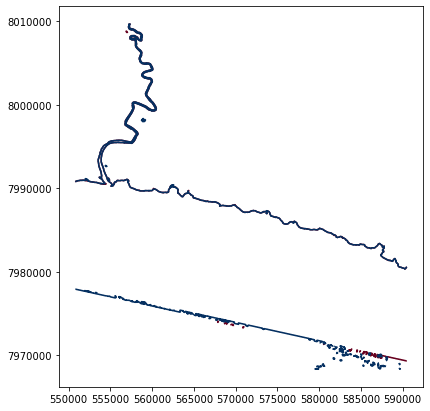

In [67]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in landsat_resampled.time.values]}
attribute_dtypes = {'time': 'str'}

# Extract waterline contours for the '0' water index threshold:
contour_gdf = waterline_funcs.contour_extract(
    z_values=[0.7],
    ds_array=landsat_resampled,
    ds_crs=landsat_ds.crs,
    ds_affine=landsat_ds.geobox.transform,
    output_shp=f'output_waterlines.shp',
    attribute_data=attribute_data,
    attribute_dtypes=attribute_dtypes,
    min_vertices=20
)



# Plot output shapefile over the top of the first year's MNDWI layer
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
#landsat_resampled.isel(time=-1).plot(ax=ax, cmap='Greys', alpha=1.0, edgecolors=None)
contour_gdf.plot(cmap='RdBu', ax=ax)


In [68]:
waterline_funcs.map_shapefile(gdf=contour_gdf)

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

In [60]:
client.restart()

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB
